# Linear Regression

Let's implement a simple linear regression using torch

In [73]:
import torch

To start with, we'll create some random data and store it as torch tensors. For now you can think of a torch tensor as equivalent to a numpy array, but we will soon see that tensors have some additional functionality that we can exploit.

In [74]:
n = 100
p = 5
x = torch.randn(n, p) # predictors (100 observations, 5 features)
y = torch.randn(n, 1) # outcomes (100 observations)

## The Model

We're looking for parameters (coefficients) $\beta$ so that 

$$
\begin{array}{rcl}
y_i & \approx & \beta_0 + x_i\beta_{1:p}  \\
&= &\beta_0 + x_{i1}\beta_1 +x_{i2}\beta_2 \dots x_{ip}\beta_p
\end{array}
$$

Although you may not have seen it represented this way before, we can also write this model as a picture:

<img src="images/linreg.png" width="250">

This will come in handy later when we get to more complex models, but for now you can think of the linear model in whatever way seems natural to you.

## The Loss


To quantify what we mean by a "good" approximation, we'll use the mean-squared-error loss. So for a given guess $\beta$ we'll give it the "grade" 

$$L(y,\hat y) = \frac{1}{n}\sum_i (y_i - \hat y_i)^2$$

where $\hat y_i  = x_i\beta_{1:p} + \beta_0$ and $n$ is the number of observations (rows) in the data. We're looking for the $\beta$ that gives us the best (lowest) grade. This combination of model (linear) and loss (mean-squared-error) is called linear regression.

## The Optimization Algorithm

There are an infinite number of possible values for $\beta$ that we could try, so it would take us forever to try them all and see which gives the best loss. To get around this problem, we need some kind of optimization algorithm that is better than brute-force search. The algorithm we will use here is an extremely useful approach called gradient descent, which you should already be familiar with from our [previous exploration]().

To start, we'll initialize the coefficients $\beta$ with random numbers. That's our first guess. We'll update these random numbers using gradient descent to iteratively find better values that make the loss smaller.

In [75]:
β = torch.randn(p+1, 1) # 5 coefficients (one per feature) plus one intercept
β.requires_grad_() # tell torch that β is going to have to save the gradient of something with respect to itself at some point

tensor([[-0.2731],
        [-0.1205],
        [-0.1281],
        [ 1.1380],
        [ 1.7139],
        [ 1.7325]], requires_grad=True)

### Autograd

Previously when using gradient descent we would have to analytically derive expressions for the gradient of the loss relative to each model parameter, implement these as functions in code, and call upon them at each gradient descent iteration. With pytorch, however, we can simply compute the current value of the loss and pytorch will automatically calculate all the necessary derivatives for us. Let's have a look.

In [76]:
ŷ = torch.matmul(x, β[1:]) + β[0] # ŷ = xβ + β0

In [77]:
L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)²/n

In [78]:
L

tensor(8.5604, grad_fn=<DivBackward0>)

In [79]:
L.backward() # compute the gradients of the loss with respect to any tensors that went into the loss with requires_grad=true

In [80]:
β.grad

tensor([[-0.4644],
        [-0.3877],
        [ 0.4751],
        [ 1.6801],
        [ 3.0645],
        [ 5.0251]])

what we see here is a vector containing all of the derivatives we want. The first element is $\frac{\delta L}{\delta \beta_0}$, the second element is $\frac{\delta L}{\delta \beta_1}$, and so on. Note that this object is part of $\beta$ and not $L$.

Let's calculate the gradient manually and make sure it matches up. We have:

$$
\begin{array}{rcl}
\hat y_i &=& x_i\beta + \beta_0 \\
L(y,\hat y) &=& \frac{1}{n}\sum_i (y_i - \hat y_i)^2
\end{array}
$$

So the derivative for $\beta_j$ with $j\ne 0$ is

$$
\begin{array}{rcl}
\frac{\partial L}{\partial \beta_j} &=& 
\frac{1}{n}
\sum_i 
\frac{\partial L}{\partial y_i} 
\frac{\partial y_i}{\partial \beta_j}
\\
&=&
\frac{1}{n}
\sum_i
-2(y_i-\hat y_i)
x_{ij}
\\
&=&
-\frac{2}{n}
x_j^T(y-\hat y)
\end{array}
$$

and for $\beta_0$ is 
$$
\begin{array}{rcl}
\frac{\partial L}{\partial \beta_0}
&=&
\frac{1}{n}
\sum_i
-2(y_i-\hat y_i) \\
&=&
-\frac{2}{n}
1^T(y-\hat y)
\end{array}
$$

which means we can calculate the whole gradient as $-\frac{2}{n}[1,x]^T(y-[1,x]\beta)$

In [81]:
import numpy as np
def beta_grad(β):
    x_with_1s = torch.Tensor(np.hstack((np.ones((n,1)), x)))
    return -2*torch.matmul(x_with_1s.transpose(0,1), y-torch.matmul(x_with_1s,β))/n

In [82]:
beta_grad(β)

tensor([[-0.4644],
        [-0.3877],
        [ 0.4751],
        [ 1.6801],
        [ 3.0645],
        [ 5.0251]], grad_fn=<DivBackward0>)

which is exactly the same as the result in `β.grad`!

How does pytorch do this? It turns out that every pytorch tensor records not only its own value, but also what functions were called to produce it and which tensors went into those functions. That's why we use torch tensors instead of numpy arrays. The `torchvis` package lets us see this:

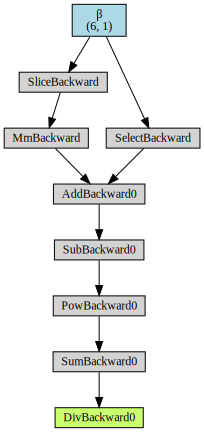

In [83]:
from torchviz import make_dot
make_dot(L, {'β':β})

To calculate the gradient of $L$ with respect to $\beta$, pytorch takes the gradients of each of these functions in turn (which are simple and hardcoded into pytorch), evaluates them at their current value using the input tensors, and multiplies them together to arrive at the answer you would get via the chain rule. You can learn more about this process [here](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95) and elsewhere.

### Doing Gradient Descent

To update the weights, we need to subtract the gradient (times a small learning rate) from the current value of the weights. 

We do this from inside a `no_grad():` "context" so that $\beta$ doesn't store the history of the update (try the update without the `with torch.no_grad():` and see what happens). We also clear out `β.grad`. 

In [84]:
with torch.no_grad():
    β -= 10e-5 * β.grad # β = β - 10e-5 * β.grad
    β.grad.zero_()

In [85]:
β

tensor([[-0.2731],
        [-0.1204],
        [-0.1282],
        [ 1.1378],
        [ 1.7136],
        [ 1.7320]], requires_grad=True)

As you can see, our new value of $\beta$ is slightly different than what we started with because we've taken a single gradient step.

**ZEROING GRADIENTS**

If we don't zero the gradient, the next time we calculate the gradient of something with respect to $\beta$, the new gradient will be added to whatever was stored there instead of overwriting it. That's just the way torch was made to work.

---
**EXERCISE**

Investigate for yourself (either by testing code or googling) why the parameter update and gradient zerioing should be performed within a `torch.no_grad()` context. 

---

#### Looping

Let's repeat what we have so far but now add a little loop to train our model for 500 gradient descent iterations instead of going slowly though a single iteration:

In [88]:
x = torch.randn(n, p) # predictors (10 observations, 5 features)
y = torch.randn(n, 1) # outcomes (10 observations)

loss_record = [] # to kep track of the loss over the iterations
β = torch.randn(p+1,1) # 5 coefficients (one per feature) plus one intercept
β.requires_grad_() # tell torch that β is going to have to save the gradient of something with respect to itself at some point

tensor([[-0.1092],
        [-1.3379],
        [ 0.2449],
        [-0.8324],
        [-0.3387],
        [ 0.4786]], requires_grad=True)

In [89]:
for e in range(500):
    ŷ = torch.matmul(x, β[1:]) + β[0] # ŷ = xβ + β0 (calculate predictions)
    L = torch.sum((y-ŷ)**2)/n # L = Σ(yᵢ-ŷᵢ)²/n (use predictions to calculate loss)
    
    L.backward() # compute gradients (in this case δL/δβ, δL/δW)
    loss_record.append(L.item())
    
    with torch.no_grad(): # take the gradient descent step 
        β -= 10e-3 * β.grad
        β.grad.zero_()

And we can see how the loss changes over the iterations:

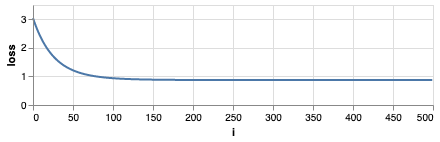

In [90]:
import altair as alt
import pandas as pd

loss_df = pd.DataFrame({'i':range(500), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

We see training loss goes down.

And here's the value of $\beta$ after 500 iterations:

In [91]:
β

tensor([[ 0.0952],
        [-0.1218],
        [-0.1502],
        [-0.1120],
        [-0.0219],
        [ 0.1727]], requires_grad=True)

Remember our original data is totally random and there is no relationship between the predictors and outcomes. So the "right" answer for what $\beta$ should be in this case is $\beta=0$. As we see above, all the values are near 0, so our algorithm appears to be converging to the right answer.

To predict for a new observation, all we have to do is multiply by $\beta$ and add the intercept:

In [92]:
new_x = torch.randn(10, 5) # 10 new observations
torch.matmul(new_x, β[1:]) + β[0] # predictions

tensor([[-0.1722],
        [ 0.3556],
        [-0.0930],
        [-0.0107],
        [-0.1134],
        [ 0.1378],
        [ 0.4761],
        [-0.3901],
        [ 0.2622],
        [-0.6157]], grad_fn=<AddBackward0>)

## Conclusion

We just developed a machine learning method out of these three components:
* linear model (model)
* MSE loss (loss)
* gradient descent (search algorithm)

These components are like interchangable parts. We're going to see how we can use a different model and loss to fit data of a different kind without fundamentally changing our search strategy.